In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [4]:
PATH = Path('./data/rnn/')

**See RNN notebook for DataBunch generation.  It is the same for all LMs, so just loaded here**

### Sentence Piece Tokenizer

In [6]:
## New Line char for replacement in text
NL = 'xxnl'
defaults.text_spec_tok.append(NL) #add a New Line special char

In [7]:
def sub_nl(t:str) -> str:
    "Replaces \n by xxnl"
    return t.replace("\r\n","\n").replace("\n",NL+" ")

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#?!@,])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, 
                 rm_useless_spaces, sub_nl]

In [8]:
model_prefix = 'all_tweets_es_0509'

In [9]:
## itos from m.vocab file: just read directly and populate the dictionary
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [10]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix,pre_rules=default_rules)
sp_vocab = Vocab(itos)

In [11]:
data = load_data(PATH,'tweet_es_lm_data_SP_more_rules.pkl')

## Bulid and train model

In [12]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 2304
print(config)

{'emb_sz': 400, 'n_hid': 2304, 'n_layers': 3, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.1, 'hidden_p': 0.15, 'input_p': 0.25, 'embed_p': 0.02, 'weight_p': 0.2, 'tie_weights': True, 'out_bias': True}


In [13]:
learn = language_model_learner(data, AWD_LSTM,drop_mult=0.5,pretrained=False,config=config)
learn.unfreeze()
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=800, out_features=6912, bias=True)
            )
          )
        )
      )
      (1): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=2304, out_features=6912, bias=True)
            )
          )
        )
      )
      (2): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=2304, out_features=1200, bias=True)
            )
          )
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RN

In [14]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


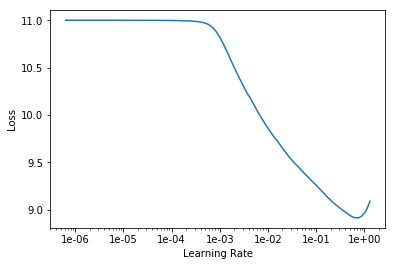

In [15]:
learn.recorder.plot(skip_end=10)

In [ ]:
learn.fit_one_cycle(10, 3e-3, moms=(0.6,0.4), wd=0.02, pct_start=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,4.865525,4.805000,0.289701,20:30


In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.fit_one_cycle(15, 1e-4, moms=(0.6,0.4), wd=0.01, pct_start=0.2)

In [ ]:
learn.save_encoder('twitter_es_enc_QRNN_0516')

In [ ]:
learn.save("twitter_raw_es_more_rules_QRNN_20190516")